In [1]:
# loading all the dependencies
import pandas as pd
import numpy as np
import uncertainties as uc

pd.options.display.float_format ='{:,.3f}'.format
import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.display import Image
from IPython.core.display import HTML 

from openpyxl import load_workbook

from scipy import integrate
import scipy.stats as stats
from uncertainties import ufloat
from uncertainties import unumpy
from itertools import groupby

from scipy.stats import gmean

%run Utility_Functions.ipynb

## Methods and Statistics
Ranges and values with ± are given as 1 standard error of the values.

Ranges in cases of large uncertainty are not necessarily symmetrical.

Boxplot showing the quartiles (25%-75%) and the median (orange horizontal line). In addition the vertical lines extending to the most extreme, non-outlier data points

# Lympocytes 
Lymphocytes are white blood cells that serve a major part in the adaptive immune system. 
They include natural killer cells (which function in cell-mediated, cytotoxic innate immunity), T cells (for cell-mediated, cytotoxic adaptive immunity), and B cells (for humoral, antibody-driven adaptive immunity).



In [2]:
#initiating a CellTypeResDF object to save results and print them:
lym = CellTypesResDF(['Thymocytes', 'Mature T cells','B cells progenitors',
                      'Transitional B cells', 'Mature B cells'],un_type='mul')   


## Lymphocytes numbers and distribution
Over the years there were few attempt to estimate the number and distribution of the lymphocytes in the human body.
The dominant sources regarding the number and spatial distribution of lymphocytes in the human is [Trepel, 1974](https://link.springer.com/article/10.1007/BF01468720) who based his estimates mainly on extrapolation from cell density measured in  rats (arrived at a total of about 0.5 trillion cells).
Over the years his estimates served as a base for most of the research. However, a research on monkeys by [Di Mascio et al., 2009](http://www.bloodjournal.org/content/114/2/328) demonstrated that larger lymphocytes densities could be found in the spleen and other organs, leading to an updated estimate of 1.9-2.9 trillion cells.  
As both sources based on non-human to derive their estimates, we choose to refer to the average of those estimates, and include a large range for errors.

The distribution of T cells, B cells and Natural Killer (NK) cells is taken from research done on humans [Westermann and Pabst, 1992](https://www.ncbi.nlm.nih.gov/pubmed/1392422). Data regarding the lymphocyte population distribution of different tissues was integrated with data regarding their overall numbers (from  [Trepel, 1974](https://link.springer.com/article/10.1007/BF01468720)) according to a method that was used in [Apostoaei and Trabalka, 2010](https://www.cdc.gov/niosh/docket/archive/pdfs/NIOSH-209/0209-010510-cllDoseReconstruction.pdf)   

In [3]:
total_lymph_data = pd.read_excel('Lymphocytes_data.xlsx','Total_lymph_data',usecols = range(0,5))
total_lymph_data.head()

#using gmean_with_errors to extract the geometrical mean and its error as a multplication factor
# using conversion to lognormal space
lymp_num, lymp_num_unc = gmean_with_errors(total_lymph_data['value'][total_lymph_data['parameter']=='total lymphocytes'])
    
lymp_dist =pd.DataFrame(total_lymph_data[['value','SD']][total_lymph_data['parameter']!='total lymphocytes'].values,index = ['T cells','B cells','NK cells'],columns=['proportion','prop. unc'])

# using uarr_to_mulfac utlity function to move from additive error to multiplication factor
lymp_dist['prop. unc'] = uarr_to_mulfac(unumpy.uarray(lymp_dist['proportion'] ,lymp_dist['prop. unc'] ))   
    
lymp_dist['number of cells'] = lymp_dist['proportion']*lymp_num

#using the 'propagate_mul_facs' utility function defined in the designated notebook to propogate the uncertiatny given as  multiplication factor
lymp_dist['cell num unc.'] = propagate_mul_facs([lymp_dist['prop. unc'].values,lymp_num_unc])

lym.res.loc['Mature T cells','number'] = tuple([lymp_dist.loc['T cells','number of cells'],
                                                round(lymp_dist.loc['T cells','cell num unc.'],1)])
lymp_dist.head()

,proportion,prop. unc,number of cells,cell num unc.
T cells,0.650,1.080,"712,039,324,756.714",2.198
B cells,0.300,1.183,"328,633,534,503.099",2.229
NK cells,0.050,2.000,"54,772,255,750.517",2.847


## T cells production
T cells production is composed of two main parts: 
1. Proliferation of mature cells (Naive/Memory)
2. Production of young cells in the Thymus
From the literature it seems that the major factor is the proliferation of mature cells, and that thymic production is less important in human. Furthermore, the tyhmic production is decreased with age as shown in the dedicated part. 



### Mature T cells proliferation

As mentioned, this is the major factor in the production of T cells. 
To estimated the lifepsan of mature T cells, and their proliferaton we use data gathered in several sources, that measured the death and proliferation of T cells using lableling with 2H in glucose or water. These expermints usually measures the level of labels over period of several weeks. Because this is only small fraction of the total lifespan of naive T cells (as we show), there is still relative big uncertainty regarding their lifespan.

We based our analysis on the sourcres selected in the reveiw by [Borghans et al.,2018](https://www.ncbi.nlm.nih.gov/pubmed/30129193). Their inclusion critreria related to the labeling technique and length of the experiments.


Boxplot representing the distribution of proliferation rates of T cells
The main body of the boxplot showing the quartiles (25%-75%) and the median (green horizontal line)
The vertical lines extending to the most extreme, non-outlier data points


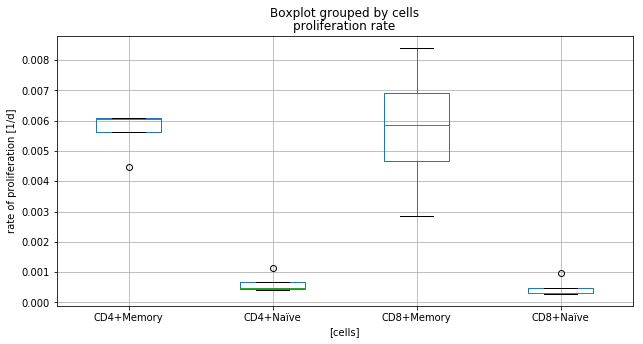

In [6]:
proliferation_data = pd.read_excel('Lymphocytes_data.xlsx','T_cells_proliferation',usecols = range(0,10))

#show the data in bloxplot 
prol2plot =  pd.DataFrame() 
prol2plot.loc[:,'cells']= proliferation_data.loc[:,'cells']
prol2plot.loc[:,'proliferation rate']= proliferation_data.loc[:,'proliferation rate (% per day) median']
prol2plot.boxplot(by='cells',figsize= (10,5))
plt.ylabel('rate of proliferation [1/d]')


# defining a function to extract the standard deviation of a log normal distribution. Given as a multiplication factor
geo_std = lambda x: 10**(np.log10(x).std()/np.sqrt(x.size))
 
prol_sum = pd.DataFrame(prol2plot.groupby(['cells']).agg(gmean), columns=['proliferation rate'])
prol_sum['prol unc.'] = prol2plot.groupby(['cells']).agg(geo_std)

prol_sum['lifespan'] = 1/prol_sum['proliferation rate']
prol_sum['lifespan unc.'] = prol_sum['prol unc.'] 

prol_sum.head()

print('Boxplot representing the distribution of proliferation rates of T cells')
print('The main body of the boxplot showing the quartiles (25%-75%) and the median (green horizontal line)')
print('The vertical lines extending to the most extreme, non-outlier data points')

Combining the proliferation data with data regarding the disbribution of the various mature T cells subpopulations 

In [7]:
cells_subpop = pd.read_excel('Lymphocytes_data.xlsx','T_Cell_Distribution',usecols = range(0,7))

#the data contain 2 rows that regard the total percentage of CD4+/CD8+ out of T cells and data regarding the distribution of 
#each subpoplation to different segments.
#here we seperate the two types of data so it can be integrated by merge.
primary_pop = cells_subpop.iloc[:2, :].rename(columns={"%": "4+/8+ % of Tcells","SD": "4+/8+ % SD"}).drop(columns=['subpopulation', 'Cells', 'markers','comment'])
minor_pop = cells_subpop.iloc[2:, ]

#merging the two types of data to calculate the overall part of different subpopulation out of the total T cell population
minor_pop = minor_pop.merge(primary_pop, how='left', on='population')
minor_pop['% T cells'] = unumpy.uarray(minor_pop['4+/8+ % of Tcells'],
                                       minor_pop['4+/8+ % SD'])*unumpy.uarray(minor_pop['%'],minor_pop['SD'])

T_subpop = minor_pop[['subpopulation','% T cells']].groupby(['subpopulation']).sum()

#we don't take in account the small population of gamam-delta, double positive/negative, Treg and more. 
#we normalize the distribution to get to 100% (to cancel possible biases)
T_subpop['% T cells']=T_subpop['% T cells']/T_subpop['% T cells'].sum()

#up until now we've taken in acount linear terms of error. We now translate them to multiplication factor for further error propagation 
T_subpop['% T cells unc.'] = uarr_to_mulfac(T_subpop['% T cells'])
    
T_subpop['% T cells'] = unumpy.nominal_values(T_subpop['% T cells'])
    

# combining the data regarding the distribution and the proliferation rates
T_subpop = T_subpop.merge(prol_sum,left_index=True,right_index=True )


#combining the data regarding the distribution of subpopulations and the overall numbers to get estiamtes for the number of each group
T_subpop['num of cells'] = T_subpop['% T cells']*lymp_dist.loc['T cells','number of cells']
#using the 'propagate_mul_facs' utility function defined in the designated notebook to propogate the uncertiatny given as  multiplication factor
T_subpop['cell num unc.'] = propagate_mul_facs([T_subpop['% T cells unc.'],lymp_dist.loc['T cells','cell num unc.']]) 

#multiplying the number estimates by the proliferation rates to get the total cellular production
T_subpop['cellular production'] = T_subpop['num of cells']*T_subpop['proliferation rate']
#using the 'propagate_mul_facs' utility function defined in the designated notebook to propogate the uncertiatny given as  multiplication factor
T_subpop['cellular production unc.'] = propagate_mul_facs([T_subpop['cell num unc.'],T_subpop['prol unc.']])

#as the uncertianty factor is very close for each of the subpopulations, and the dominamnt population is this of CD+4 Memory we use its unc. factor
total_T_production = T_subpop['cellular production'].sum()
total_T_production_unc = T_subpop.loc['CD4+Memory','cellular production unc.']

#saving the results to the results object
lym.res.loc['Mature T cells','cellular turnover rate'] = total_T_production, total_T_production_unc 

#deriving the mean lifespan from the overall production and numbers
#but the uncertainty is in the order of magnitude of the uncertainty of the lifespan of individual subpopulations
# we take the max of their uncertainty and not the propogation of the error of cellular production as there is a large depended factor 
#owning to the large uncertianty in the number of total T cell

T_mean_lifespan = lymp_dist.loc['T cells','number of cells']/total_T_production 
T_mean_lifespan_unc = T_subpop['lifespan unc.'].max()

#saving the results to the results object and using it to print 
lym.res.loc['Mature T cells','lifespan'] = T_mean_lifespan,T_mean_lifespan_unc 
lym.print_params(['number','cellular turnover rate','lifespan'],'Mature T cells')



Number of Mature T cells is: 7e+11 cells (SD range: 3e+11 - 2e+12 cells)
Cellular turnover rate of Mature T cells is: 2e+09 cells per day (SD range: 1e+09 - 5e+09 cells per day)
Lifespan of Mature T cells is: 320 days (SD range: 240 - 440 days)


### Production of T cells in the Thymus
The thymus has a major contribution to production of cells in the first years of life but it is degrading with age, as the thymus shrinks in a process called "thymic involution" (unlike human, in mice the thymic contribution remains dominant throughout their lifespan)

Thymocytes inside the Thymus undergo a rapid process of selection from which only few percents survive. 

We use measurments of thymic output taken from humans [den Braber et al., 2012](https://www.ncbi.nlm.nih.gov/pubmed/22365666) and combine it with estimate for the number of cells in the thymus and their survivability to estimate the death rate of the thymocytes.


The number of cell in the Thymus was estimated based on three methods :
1. [Trepel, 1974](https://link.springer.com/article/10.1007/BF01468720) - give an estimate for the total number of lymphocytes inside the Thymus (extrapolating from data regarding rats).
2. [Marušić et al., 1998](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1904903/) measured the density of thymocytes per gram. We multiply it by the mass of the Thymus (of adults), taken from [Snyder et al., 1975](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2023)
3. Integration of thymic output taken from humans [den Braber et al., 2012](https://www.ncbi.nlm.nih.gov/pubmed/22365666) and the ratio of between cells output and the total numebr of cells taken from mice ([Thomas-Vaslin et al., 2008](https://www.ncbi.nlm.nih.gov/pubmed/18250431), [Scollay et al., 1986](https://www.ncbi.nlm.nih.gov/pubmed/3525392), [Penit, 1986](https://www.ncbi.nlm.nih.gov/pubmed/3093565), [Egerton et al., 1990](https://www.ncbi.nlm.nih.gov/pubmed/2138780))  


In [8]:
Thymus_data = pd.read_excel('Lymphocytes_data.xlsx','Thymus_data',usecols = range(0,6),index_col=0)

Thymus_output = ufloat(Thymus_data.loc['thymic production of CD4+','value'],
                       Thymus_data.loc['thymic production of CD4+','SD'])*(1+1/Thymus_data.loc['CD4+/CD8+ ratio in Thymus','value'])

exported_thymocytes_perc = Thymus_data['value'][Thymus_data.index =='exported thymocytes as % of total thymocytes'].mean()

#we define a serie to contain the different estimate for the number of cells in the thymus 
Thymus_cells_estimate = pd.Series(index = ['Treprel,1974 based','density based','output based'])

Thymus_cells_estimate['output based']=Thymus_output.nominal_value/exported_thymocytes_perc
Thymus_cells_estimate['Treprel,1974 based']= Thymus_data.loc['thymus lymphocytes','value']
Thymus_cells_estimate['density based']=Thymus_data.loc['thymocytes density','value']*Thymus_data.loc['thymus mass','value']

#we take the reference value to be the geometric mean of the different estimates, with its uncertainty derived from the log distribution
#the uncertainty is calculated as the SEM (standard error of the mean = SD/sqrt(n))
# using the gmean_with_errors utility function
lym.res.loc['Thymocytes','number'] = gmean_with_errors(Thymus_cells_estimate)

#the death rate equal to the proportion of thymocytes that are dying in relation to the  prodaction rate as % of total thymocytes 
#we use a simple model taken from [Thomas-Vaslin et al., 2008] - we assume their a constant rate of cells leaving the compartment
#large percent of them die and the other part mature and being exported 

#we use the ratios to get an estimate for the lifespan of thymocytes in *mice*
#we then use the connection between lifespan of cells in mouse and in human to derive an extrapolated
#turnover estimate as a bound for human
mouse_thymocytes_death_rate = Thymus_data.loc['daily production of thymocytes % of total','value']*Thymus_data.loc['thymocytes dying ','value']
mouse_thymocytes_lifespan = 1/mouse_thymocytes_death_rate


#the uncertainty in the estimate of the lifespan is due to the uncertainty in the estiamte of:
# 'production of thymocytes as % of total thymocytes'
#we can see that that uncertainty is connected to the uncertiany of the experssion for exported thymocytes as % of total thymocytes
# as: (exported thymocytes as % of total thymocytes)*(thymocytes exported)= production of thymocytes as % of total thymocytes
#while the uncertainty of 'thymocytes exported' is relativly small

expor_thym_data = Thymus_data['value'][Thymus_data.index =='exported thymocytes as % of total thymocytes']
exported_thymocytes_perc_unc = 10**(np.log10(expor_thym_data).sem())
mouse_thymocytes_lifespan_unc = exported_thymocytes_perc_unc

lym.res.loc['Thymocytes','lifespan in rodents'] = mouse_thymocytes_lifespan, mouse_thymocytes_lifespan_unc

#using the lifespan in rodent to derive an extrapolated estimate for turnover in human
# propagating the error of the log normal variables using the utility function
ext_to_rate = lym.res.loc['Thymocytes','number'][0]/mouse_thymocytes_lifespan
ext_to_rate_unc = propagate_mul_facs([lym.res.loc['Thymocytes','number'][1],mouse_thymocytes_lifespan_unc])

lym.res.loc['Thymocytes','extrapolated cellular turnover rate'] = ext_to_rate, ext_to_rate_unc

print('production of mature T cells from thymus: {:0.1eP} cells per day'.format(Thymus_output))
lym.print_params(['number','lifespan in rodents','extrapolated cellular turnover rate'],'Thymocytes')


production of mature T cells from thymus: (3.3±0.9)×10⁷ cells per day
Number of Thymocytes is: 2e+09 cells (SD range: 5e+08 - 1e+10 cells)
Lifespan in rodents of Thymocytes is: 3.8 days (SD range: 1.6 - 8.7 days)
Extrapolated cellular turnover rate of Thymocytes is: 6e+08 cells per day (SD range: 1e+08 - 4e+09 cells per day)


## B cells production
B cells production is composed of three main parts: 
1. production of transitional B cells from the B cell progenitors in the bone marrow (BM), including pro/pre B cells and immature B cells.
2. maturation of transitional B cells in the spleen into naive mature cells
3. Proliferation of mature cells (Naive/Memory)


During the first two parts there is an excessive lose of cell due to strong selection. 


### Production of B cells from progenitors in the bone marrow
Bone marrow cellularity data from [Harrison, 1962](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC480393/), and the distribution of the various bone marrow progenitors was taken from [Agrawal et al., 2013](https://www.ncbi.nlm.nih.gov/pubmed/23731328)

The BM pogenitors includes the pro/pre B cell and the immature B cells inside the BM. 
Pro-B and some of the Pre-B cells are undergo mitosis and thus produce constant flow of new cells that undergo selection. Some of them mature and some die in the process.

Using similar model for selection and maturation in the bone marrow as for T cells in the Thymus- there is a constant flow of new cells produced by the mitotic population equal to the constant flow of cells that either die or mature.

The death rate is calculated from the proportion of cells that are being lost (die) per day in relation to the total number of progenitors B cells in the bone marrow compartment 

We use data from mice regarding the turnoevr rate at the different stages, combined with data from human regarding the number cells to get an extrapolated turnover rate that can serve as an upper bound

In [9]:
BM_cellularity_data= pd.read_excel('Lymphocytes_data.xlsx','BM_cellularity',usecols = range(0,4),index_col=0)
B_prog_data= pd.read_excel('Lymphocytes_data.xlsx','B_progenitors_turnover',usecols = range(0,6),index_col=0)


In [10]:
#bone marrow cellularity data taken from Harrison, 1962
BM_nuc_cell_per_kg = unumpy.uarray(BM_cellularity_data['value'].iloc[:2],BM_cellularity_data['SD'].iloc[:2]) 
BM_nuc_cell = BM_nuc_cell_per_kg.mean()*70

#lympocytes line percentage out of BM nuclueted cells
BM_lymp_perc = BM_cellularity_data.loc['Lymphocyte nuceleated cells','value']*ufloat(BM_cellularity_data.loc['bone marrow B cell proportion','value'],
                                                                                     BM_cellularity_data.loc['bone marrow B cell proportion','SD'])

total_BM_Bcells = BM_lymp_perc*BM_nuc_cell


pre_proB =  total_BM_Bcells*(BM_cellularity_data.loc['Pre-B I /B lymph','value']+BM_cellularity_data.loc['Pre-B II/ B lymph','value'])
ImmatureB_num = total_BM_Bcells*BM_cellularity_data.loc['Immature/ B lymph','value']

#the difference in definitions of  Pre I and Pre II in from the srouce is not so clear.
# we want to now the mitotic portion. We use the data from mice and rats to make up for the missing data

mitotic_proportion = ufloat(B_prog_data[['value - rats','value - mice']].loc['mitotic (Pro/large Pre B) poportion'].mean(axis=0),
                              B_prog_data[['value - rats','value - mice']].loc['mitotic (Pro/large Pre B) poportion'].std(axis=0))


mitotic_prog = pre_proB*mitotic_proportion 
non_mitotic_preB = pre_proB-mitotic_prog

#assuming the for turnover rates are close to that of rats, and the uncertainty is geomtrical,taken from the proportion of rats and mice.
mitotic_rates = [B_prog_data.loc['production rate of cells (from mitotic)','value - mice'],B_prog_data.loc['production rate of cells (from mitotic)','value - rats']]

#using the mice data to derive the lifespan in mice and from it the human lifespan
mitot_prod_rate = B_prog_data.loc['production rate of cells (from mitotic)','value - mice']*24 

#computing the uncertainty using the standard deviation of the values of mice and rats in logspace
mitot_prod_rate_unc = 10**(np.log10(mitotic_rates).std())


non_mitot_flow_rate = B_prog_data.loc['turnover rate of non-mitotic ','value - mice']*24 #the same for rat and mice, moving from 1/hour to 1/day

#estimating the death rate in mice from the mitotic production minus the non-mitotic flow
mouse_preB_death_rate = mitotic_proportion.nominal_value*mitot_prod_rate - (1-mitotic_proportion.nominal_value)*non_mitot_flow_rate
mouse_preB_death_rate_unc = mitot_prod_rate_unc 

#geting teh lifespan in mouse from the average death rate
perB_mouse_lifespan = 1/mouse_preB_death_rate
perB_mouse_lifespan_unc = mitot_prod_rate_unc


#calculating the extrapolated turnover rates from the death rate of the two population and from them
# the overall lifespan in rodents

BM_prog_ext_to = pre_proB.nominal_value/perB_mouse_lifespan
BM_prog_ext_to_unc = propagate_mul_facs([ufloat_to_mulfac(pre_proB),perB_mouse_lifespan_unc])

#using the death rate given for mice immature B cells
mouse_im_B_death_rate  = ufloat(B_prog_data.loc['immature death rate','value - mice'],
                                B_prog_data.loc['immature death rate','SD - mice'])

#computing the extrapolated rate using the ufloats and then converting to multiplication factors
Im_B_ext_to = (ImmatureB_num*mouse_im_B_death_rate).nominal_value
Im_B_ext_to_unc = ufloat_to_mulfac(ImmatureB_num*mouse_im_B_death_rate)

# summing the two turnover (death) rates and noticing that BM is much greater, 
# so we can use only its uncertainty
prog_B_ext_to = BM_prog_ext_to + Im_B_ext_to
prog_B_ext_to_unc = BM_prog_ext_to_unc

lym.res.loc['B cells progenitors',
            'extrapolated cellular turnover rate'] = prog_B_ext_to, prog_B_ext_to_unc


#using the overall extrapolated death rates of the B progenitors we derive the effective lifespan
# from rodents by dividing by their total numbers

#Summing the two populations of progenitors cells and estimating their uncertainties, aggregated lifespan and turnover
total_prog_num = (pre_proB+ImmatureB_num).nominal_value
total_prog_num_unc = ufloat_to_mulfac(pre_proB+ImmatureB_num)

lym.res.loc['B cells progenitors','number'] = total_prog_num, total_prog_num_unc


prog_B_ls_in_rodents = total_prog_num/prog_B_ext_to
prog_B_ls_in_rodents_unc = propagate_mul_facs([total_prog_num_unc,prog_B_ext_to_unc])

lym.res.loc['B cells progenitors','lifespan in rodents'] = prog_B_ls_in_rodents, prog_B_ls_in_rodents_unc 

lym.print_params(['number','extrapolated cellular turnover rate',
                  'lifespan in rodents'],'B cells progenitors')





Number of B cells progenitors is: 6e+09 cells (SD range: 4e+09 - 8e+09 cells)
Extrapolated cellular turnover rate of B cells progenitors is: 7e+09 cells per day (SD range: 4e+09 - 1e+10 cells per day)
Lifespan in rodents of B cells progenitors is: 0.8 days (SD range: 0.4 - 1.6 days)


### Maturation and death of transitional B cells
Transitional B cells are produced in the bone marrow from immature cells and emigrate to the spleen to mature there. Most of them reside in the spleen (such that the popultion in the bone marrow and blood are negligible). 
We estimate their numbers using estimate for the total B lymphocyte population of the spleen, based on [Trepel, 1974](https://link.springer.com/article/10.1007/BF01468720), [Di Mascio et al., 2009](http://www.bloodjournal.org/content/114/2/328), [Westermann and Pabst, 1992](https://www.ncbi.nlm.nih.gov/pubmed/1392422). 

We used data from [Palanichamy et al., 2009](https://www.ncbi.nlm.nih.gov/pubmed/19414749) and [Benitez et al., 2014](https://www.ncbi.nlm.nih.gov/pubmed/24719464) regarding the fraction of B transitional cells in the human spleen (seems to be much smaller than 20% mentioned for mice in [Rolink et al., 1998](https://www.ncbi.nlm.nih.gov/pubmed/9842916).
There is a little confusion in the measurment as there are several schemes for sorting the cells according to various surface marker, but it seems our derivation converges to similar estimates.

The lifespan of transitional B cells were estimated from mice data, based on death rate derived by [Rolink et al., 1998](https://www.ncbi.nlm.nih.gov/pubmed/9842916) and [Shahaf et al., 2016](https://www.ncbi.nlm.nih.gov/pubmed/27047488)

In [11]:
B_trans_data= pd.read_excel('Lymphocytes_data.xlsx','B_transitional',usecols = range(6),index_col=0)

# we use the utitily function 'gmean_with_errors' to calculate the geometric mean and the error as a
# multiplication factor
spleen_lymp_data = B_trans_data['value'][B_trans_data.index=='spleen lymphocytes'].values
spleen_total_lymp, spleen_total_lymp_unc = gmean_with_errors(spleen_lymp_data)


#we estiamte the fraction of transitional B cells in the spleen according to two sources: Palanichamy et al., 2009 and Benitez et al., 2014
spleen_fractions_transB = pd.Series(index = ['Palanichamy et al., 2009','Benitez et al., 2014']) 
#Palanichamy et al., 2009 give their estimate in the SI. the use a scheme that divide 3 types. It seems the third type (T3) is
# not concerned in other schemes
spleen_fractions_transB['Palanichamy et al., 2009'] = B_trans_data.loc['tansitional B cells /total B cells in spleen',
                                                                       'value']

#Benitez et al., 2014 gives the fraction of trans B cells in the spleen, out of non-memory B cell pool. 
# we use their approximation, that for adult human about 40% of B cells are memory, to estimate the overall fraction of transitional B cells 
spleen_fractions_transB['Benitez et al., 2014'] = B_trans_data.loc['adult Memory B cells/mature B cells',
                                                                   'value']*B_trans_data.loc['spleen tranisional B/non-memory B cells','value']

#we take the geomtric mean of the two values and estimate the multiplicating factor of uncertainty 
ref_frac_transB, ref_frac_transB_unc = gmean_with_errors(spleen_fractions_transB)


#using the total number of B cells and the fraction of transitional B cells to estimate their total numbers
spleen_tranB =spleen_total_lymp*ref_frac_transB*B_trans_data.loc['B cell proportion in spleen','value']
#using the 'propagate_mul_facs' utility function defined in the designated notebook to propogate the uncertiatny given as  multiplication factor
spleen_tranB_unc =  propagate_mul_facs([spleen_total_lymp_unc,ref_frac_transB_unc])

#saving the total number of Transitional B cells in the results dataframe class
lym.res.loc['Transitional B cells','number'] = spleen_tranB, spleen_tranB_unc

#deriving the death rate for mice from two different sources:
mouse_tranB_death_rate = pd.Series(index = ['Shahaf et al.,2016','Rolink et al.,1998']) 

#'Shahaf et al.,2016' is taken stright from their results (modeling mathematcly the population)
mouse_tranB_death_rate['Shahaf et al.,2016'] = ufloat(B_prog_data.loc['transitional death rate','value - mice'],
                                                      B_prog_data.loc['transitional death rate','SD - mice'])

#'Rolink et al.,1998' is derivied from their estimate - how many cell survive, after what time
percents_die = 1- B_prog_data.loc['% of transiltional cells mature ','value - mice']
residence_time = ufloat(B_prog_data.loc['transitional residence time ','value - mice'],B_prog_data.loc['transitional residence time ','SD - mice'])

mouse_tranB_death_rate['Rolink et al.,1998']=percents_die/residence_time

mouse_tranB_death_rate = mouse_tranB_death_rate.sum()/2

mouse_tranB_lifespan = 1/mouse_tranB_death_rate

lym.res.loc['Transitional B cells','lifespan in rodents'] = tuple([mouse_tranB_lifespan.nominal_value,
                                                                   ufloat_to_mulfac(mouse_tranB_lifespan)])

#integrating the overall cellular death rate (turnover)
total_tranB_death = spleen_tranB/ lym.res.loc['Transitional B cells','lifespan in rodents'][0]
#using the 'propagate_mul_facs' utility function defined in the designated notebook to propogate the uncertiatny given as  multiplication factor
total_tranB_death_unc =  propagate_mul_facs([spleen_tranB_unc,
                                             lym.res.loc['Transitional B cells','lifespan in rodents'][1]])

lym.res.loc['Transitional B cells',
            'extrapolated cellular turnover rate'] = total_tranB_death, total_tranB_death_unc 

#printing using the restuls class method 
lym.print_params(['number','lifespan in rodents',
                  'extrapolated cellular turnover rate'],'Transitional B cells') 
    
    
#for comparison we can look at the production rate of transitional cells from immature cells:
#(as mentioned, most of them leave the bone marrow)
print('____________')
print('For comparison we can look at the production of transitional cells from immature cells ')
# print('Production of transitional B cells in the BM (from immature B cells) {:0.1eP} cells per day'.format(immature_diff))

dying_fraction = residence_time*mouse_tranB_death_rate
print('About {:0.0fP}% of the transitional B cells die before maturing'.format(100*dying_fraction))


Number of Transitional B cells is: 3e+09 cells (SD range: 1e+09 - 7e+09 cells)
Lifespan in rodents of Transitional B cells is: 10 days (SD range: 8 - 12 days)
Extrapolated cellular turnover rate of Transitional B cells is: 3e+08 cells per day (SD range: 1e+08 - 7e+08 cells per day)
____________
For comparison we can look at the production of transitional cells from immature cells 
About 44±7% of the transitional B cells die before maturing


Those two estimates seem close enough.

We can look at the extrapolated production of mature B cells from the spleen (derived from mice data):

In [12]:
maturating_fraction = 1-dying_fraction
mature_prod = spleen_tranB*maturating_fraction/residence_time
#using the 'FacMulProp' utility function defined in the designated notebook to propogate the uncertiatny given as  multiplication factor
# mature_prod_unc =  FacMulProp([spleen_tranB_unc,tranB_death_rate_unc])
  
print('maturation of {:0.0eP} B cells per day'.format(mature_prod))


maturation of (4±1)×10⁸ B cells per day


### Mature B cells proliferation

To estimated the lifespan of mature B cells, and their proliferation we use data gathered in several sources, that measured the death and proliferation of B cells using labeling with 2H in glucose or water. These experiments usually measures the level of labels over period of several weeks.
We based our analysis on the sources selected in the review by [Borghans et al.,2018](https://www.ncbi.nlm.nih.gov/pubmed/30129193). Their inclusion criteria were related to the labeling technique and length of the experiments.

We use reference data from, taken from blood, for the relative fraction of the different B cell subpopulations.
We use data from [Apoil et al., 2017](https://www.ncbi.nlm.nih.gov/pubmed/28491945) and [Timmermans et al., 2016](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0160103#sec023). We should note that the two sources used differnt schemes for differentiating between the subpopulation and so we only concentrating on the three subpopulation for which we have proliferation rate data

Boxplot representing the distribution of proliferation rates of B cells
The main body of the boxplot showing the quartiles (25%-75%) and the median (green horizontal line)
The vertical lines extending to the most extreme, non-outlier data points


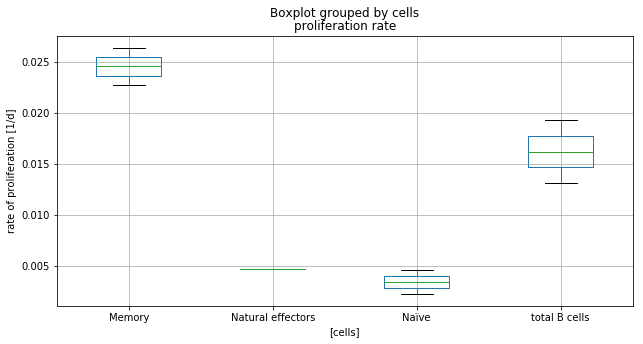

In [15]:
Bproliferation_data = pd.read_excel('Lymphocytes_data.xlsx','B_cells_proliferation',usecols = range(6))

#show in bloxplot the data
prol2plot =  pd.DataFrame() 
prol2plot.loc[:,'cells']= Bproliferation_data.loc[:,'cells']
prol2plot.loc[:,'proliferation rate']= Bproliferation_data.loc[:,'proliferation rate (1/d)']
prol2plot.boxplot(by='cells',figsize= (10,5))
plt.ylabel('rate of proliferation [1/d]')

Bprol_sum = pd.DataFrame(prol2plot.groupby(['cells']).agg(gmean), columns=['proliferation rate'])
Bprol_sum['prol unc.'] = prol2plot.groupby(['cells']).agg(geo_std)

# Bprol_sum = pd.DataFrame(unumpy.uarray(prol2plot.groupby(['cells']).mean(),prol2plot.groupby(['cells']).std()/np.sqrt(2))
#               ,index = prol2plot.groupby(['cells']).groups.keys(), columns=['proliferation rate'])

#for natural effectors B cells we have only 1 value, so we use the SD of the the source as a Standard error of the mean
Bprol_sum.loc['Natural effectors',
              'prol unc.'] = ufloat_to_mulfac(Bprol_sum.loc['Natural effectors','proliferation rate'],
                                              Bproliferation_data['SD proliferation (1/d)'][Bproliferation_data['cells'] == 'Natural effectors'].values)

Bprol_sum['lifespan'] = 1/Bprol_sum['proliferation rate']

Bprol_sum.head()

print('Boxplot representing the distribution of proliferation rates of B cells')
print('The main body of the boxplot showing the quartiles (25%-75%) and the median (green horizontal line)')
print('The vertical lines extending to the most extreme, non-outlier data points')

We combined the proliferation data for the subpopulations with data regarding their fraction of B cell population to compute the overall turnoevr. We can compare the results we get from the subpopulations (which acount for ≈90% of the cells) to that of the total B cell population and derive the turnover of the fraction we didn't acount for. This way we get an estimates for the lifespan of the rest of the cells, and we can check if it is reasnoable.     

In [16]:
B_subpop = pd.read_excel('Lymphocytes_data.xlsx','B_Cell_Distribution',usecols = range(5),index_col=0)

#merging the two data sources, such that only cells we acounted for remain
B_subpop= Bprol_sum.merge(B_subpop,left_index=True,right_index=True)





# converting error given as additive to multiplication factors using 'uarr_to_mulfac' utility function
# that take a unumpy.uarray
B_subpop['popul frac unc.'] = uarr_to_mulfac(unumpy.uarray(B_subpop['%'],B_subpop['SD']))

B_subpop['total cells'] = (lymp_dist.loc['B cells','number of cells']-spleen_tranB-total_prog_num)*B_subpop['%']

#error propogation for the uncertainty in total cells,using the 'propagate_mul_facs' utility function defined in the designated notebook to propogate the uncertiatny given as  multiplication factor
B_subpop['total cells unc.'] =  propagate_mul_facs([B_subpop['popul frac unc.'],lymp_dist.loc['B cells','cell num unc.']])

#computing the turnvoer using the proliferation rate and the total cell number
B_subpop['turnover rates'] = B_subpop['total cells']*B_subpop['proliferation rate']
# using the 'propagate_mul_facs' utility function defined in the designated notebook to propogate the uncertiatny given as  multiplication factor
B_subpop['turnover rates unc.'] =  propagate_mul_facs([B_subpop['total cells unc.'],B_subpop['prol unc.']])

#caculating the turnover from either the subpopulation fractions and the totalpopulation
to_from_subp= B_subpop['turnover rates'][B_subpop.index!='total B cells'].sum(axis=0)
to_from_totalB = B_subpop['turnover rates'][B_subpop.index=='total B cells'].sum(axis=0)

#the difference need to be explained by the fraction of unaccounted cells:
remain_cells = B_subpop.loc['total B cells','total cells']-B_subpop['total cells'][B_subpop.index!='total B cells'].sum(axis=0)
remain_to = to_from_totalB-to_from_subp


#we can estimate their lifespan using the ratio of turnover to number of cells
remain_cells_lifespan = remain_cells/remain_to


print('Mean lifespan of the unaccounted B cells is {:0.0f} days'.format(remain_cells_lifespan))


Mean lifespan of the unaccounted B cells is 13 days


That seems to be low estimate, as B memory cells have lifespan of 40 days in comparison. Closer to the value of transitional B cells.
It could be due to underestimation of the memory cell fraction (as some source indicate they contibure larger portion). 
We assumed that the subpopulation fractions from the blood represent those of the total population, and it could be another source of error. 

For our concluding estimate for the turnoevr of mature B cell we use the estimate based on the mean proliferation rate of the total B population.

In [17]:
lym.res.loc['Mature B cells','number'] = tuple([B_subpop.loc['total B cells','total cells'],
                                                lymp_dist.loc['B cells','cell num unc.']])

lym.res.loc['Mature B cells','lifespan'] = tuple([B_subpop.loc['total B cells','lifespan'],
                                                  B_subpop.loc['total B cells','prol unc.']])
#the uncertainty is as the proliferation rate unc.

lym.res.loc['Mature B cells','cellular turnover rate'] = tuple([B_subpop.loc['total B cells','turnover rates'],
                                                                B_subpop.loc['total B cells','turnover rates unc.']])

lym.print_params(['number','lifespan','cellular turnover rate'],'Mature B cells')


Number of Mature B cells is: 3e+11 cells (SD range: 1e+11 - 7e+11 cells)
Lifespan of Mature B cells is: 63 days (SD range: 52 - 76 days)
Cellular turnover rate of Mature B cells is: 5e+09 cells per day (SD range: 2e+09 - 1e+10 cells per day)


## Lymphoctes mass and cellular mass turnover rates

We use measurement of lymphocyes from the literature, taken by two main methods:  Coulter counter and Flow Cytometer.
We gathered the data from 5 primary sources:  [Schmid-Schönbein et al., 1980](https://www.ncbi.nlm.nih.gov/pubmed/6775712?dopt=Abstract), [Segel et al., 1981](https://www.ncbi.nlm.nih.gov/pubmed/7214019), [Kuse et al., 1985](https://link.springer.com/article/10.1007/BF00320301), [Downey et al., 1990](https://www.ncbi.nlm.nih.gov/pubmed/2272970) and [Zheng et al., 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4287721/).

We use density measured in [Grover et al., 2011](https://www.pnas.org/content/108/27/10992) to derive the mass from the volume measurments.

Du to lack of relevant information, We don't differentiate between the different lymphocytes subpopulations.



In [18]:
lymp_mass_data =  pd.read_excel('Lymphocytes_data.xlsx','Lymph_mass',usecols = range(0,4),index_col=0)
lymp_density = 1.077 #pg/fl Zipursky et al., 1976
lymp_mass = lymp_density*ufloat(lymp_mass_data['value (fl)'].mean(axis=0),
                                lymp_mass_data['value (fl)'].sem(axis=0))


Now we can use the reference mass to estimate the cellular mass turnoevr of each of the subpopulations:

In [19]:

#approximating the low uncertainties of the mass with a mupltiplication factor to enable propogation
lymp_mass_unc= round(ufloat_to_mulfac(lymp_mass),2)
lymp_mass = lymp_mass.nominal_value
# using the 'propagate_mul_facs' utility function defined in the designated notebook to propogate the uncertiatny given as  multiplication factor
# B_subpop['turnover rates unc.'] = propagate_mul_facs([B_subpop['total cells unc.'],B_subpop['prol unc.']])

# we use list and zip to enable assingment of tuple to the entire column
cell_types_num = lym.res.index.size
lym.res['cell mass'] = list(zip(lymp_mass*np.ones(cell_types_num),
                                lymp_mass_unc*np.ones(cell_types_num)))

# we comute the total cellular mass from the mupltilication of the number and cell mass
#using list and zip to wrap the vectors into a vector of tuples (value, uncertainty) 
#the same done for computing the cellular mass turnover, using cellular turnover instead of numbers

lym.res['total cellular mass']  = list(zip(lym.get_param_vals('number')*lymp_mass/10**12,
                                          propagate_mul_facs([lym.get_param_unc('number'),lymp_mass_unc])))


lym.res['cellular mass turnover rate']  = list(zip(lym.get_param_vals('cellular turnover rate')*lymp_mass/10**12,
                                                   propagate_mul_facs([lym.get_param_unc('cellular turnover rate'),lymp_mass_unc])))

lym.res['extrapolated cellular mass turnover rate']  = list(zip(lym.get_param_vals('extrapolated cellular turnover rate')*lymp_mass/10**12,
                                                       propagate_mul_facs([lym.get_param_unc('extrapolated cellular turnover rate'),lymp_mass_unc])))


lym.print_params(['total cellular mass','cellular mass turnover rate',
                 'extrapolated cellular mass turnover rate'])

Thymocytes:
Total cellular mass of Thymocytes is: 0.43 grams (SD range: 0.09 - 2.10 grams)
Extrapolated cellular mass turnover rate of Thymocytes is: 0.11 grams per day (SD range: 0.02 - 0.69 grams per day)
______________________________
Mature T cells:
Total cellular mass of Mature T cells is: 132 grams (SD range: 60 - 290 grams)
Cellular mass turnover rate of Mature T cells is: 0.4 grams per day (SD range: 0.2 - 0.9 grams per day)
______________________________
B cells progenitors:
Total cellular mass of B cells progenitors is: 1.0 grams (SD range: 0.7 - 1.5 grams)
Extrapolated cellular mass turnover rate of B cells progenitors is: 1.2 grams per day (SD range: 0.7 - 2.2 grams per day)
______________________________
Transitional B cells:
Total cellular mass of Transitional B cells is: 0.5 grams (SD range: 0.2 - 1.3 grams)
Extrapolated cellular mass turnover rate of Transitional B cells is: 0.05 grams per day (SD range: 0.02 - 0.13 grams per day)
______________________________
Mature B

## Saving the results to excell
For further use

In [20]:
lym.export_to_excel('Summary.xlsx')